# Using the Atmospheric Blocking 1D Model

### Requirements:
* NumPy
* H5Py (for HDF5 support)
* matplotlib

In [1]:
import AtmosphericBlocking
import numpy as np
import h5py
import sys,os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# A0  = \lambda  (1 - cos (2 n \pi x/Lx) )  (1 + \mu)  

The equation our model solves is $$\frac{\partial}{\partial t}\hat{A}(x,t) = - \frac{\partial}{\partial x}\left[\left(C(x)-\alpha\hat{A}\right)\hat{A}\right]+\hat{S}-\frac{\hat{A}}{\tau}+D\frac{\partial^2\hat{A}}{\partial x^2}$$

There are two directions in which we can explore this: forcing and background conditions (set by $C(x)$).

The background $C(x)$ is defined as $$C(x) = u_\text{ref} + c_g - 2\alpha A_0(x)$$
where $$A_0(x) = Y\left[1-\cos\left(\frac{2\pi nx}{L_x}\right)\right]$$ where $Y$ is the amplitude and $n$ is the wavenumber of the background stationary wave $A_0$.

The total LWA is $$A = A_0+\hat{A}.$$

Zonal LWA flux is defined as $$F(x,t) = \left(C(x)-\alpha\hat{A}(x,t)\right)\hat{A}(x,t)$$
while eastward wind $u(x,t)$ is defined as $$u(x,t) = 40-\alpha A.$$

So if we want to vary $C(x)$, there are three things we can play with:
  * $\beta = u_\text{ref} + c_g$
  * $Y$
  * $n$

In [2]:
def gaussforce(x,t,peak=2,inject=True,tw=2.5,xw=2800.0e3,xc=16800.0e3,tc=277.8):
  # Gaussian centered at 277.8 days and 16,800 km
    tc = tc
    tw = tw
    t = t/86400.0
    xc = xc
    xw = xw
    sx = 1.852e-5 + np.zeros(len(x))
    if inject:
        sx *= (1+peak*np.exp(-((x-xc)/xw)**2 - ((t-tc)/tw)**2))
    return sx

In [3]:
def noboru_cx(x,Lx,alpha):
  # The background conditions used in Noboru's paper
    A0 = 10*(1-np.cos(4*np.pi*x/Lx))
    cx = 60 - 2*alpha*A0
    return cx,A0

We would like to add random forcing, so that we can run many iterations of the same parameters and collect statistics. We could simply add white noise or red noise, but the problem is that the average background forcing must be quite a bit lower than the peak forcing events to avoid total and perpetual saturation, and those peak forcing events must be relatively sparse. Additionally, we would like the spatial scale and longevity of these forcing events to be more or less comparable to realistic forcing events. Since those events might be things like explosive cyclogenesis, we want to limit our forcing events to size scales of a few hundred kilometers at the largest. 

The solution we settle on involves a simple linear superposition of waves, such that on rare occasion, constructive interference produces a large peak, and at most points destructive interference either wins or balances the constructive interference.

We can therefore define the basic form of the forcing as $$\hat{S}_w(x,t) = \frac{1}{N_f}\sum_{i}^{N_f}w_i\sin\left(\frac{2\pi f_i}{L_x}x+v_i t + \phi_i\right)$$
where $N_f$ is the number of waves we would like to combine, $w_i$ is the amplitude of the wave, $f_i$ is its frequency, $v_i$ is its propagation speed, and $\phi_i$ is its phase. All variables with the subscript $i$ are randomly sampled from a uniform distribution. In the function below, they are prescribed as function arguments, so that a random set can be generated, saved, and used to reproduce a specific forcing. To increase the peakiness of the forcing, and to scale it appropriately, we define $$\hat{S}(x,t) = 1.852\times10^{-5}\times{\max}\left(1,1+{\hat{S}_w}^3(x,t)\right)$$
This ensures that the forcing does not fall below the background forcing specified in Noboru's paper, avoids negative forcing, and sharply increases the contrast between peak forcing and average forcing while also narrowing the peaks.

We also hold off on doing this until after 270 days, applying a flat forcing until then. This gives the model time to spin up.

In [4]:
def noiseforce(x,t,peak=2,inject=True,freqs=np.arange(10),speeds=np.arange(10),
               phases=np.zeros(10),ampls=np.ones(10),Lx=28000.0e3,tw=2.5,
               xw=2800.0e3,xc=16800.0e3,tc=277.8):
    if t/86400<270:
        return np.zeros(x.shape)+1.852e-5
    sx = np.zeros(x.shape)
    wampls = ampls*peak
    for i in range(0,len(freqs)):
        sx += 1.0/len(freqs)*wampls[i]*\
                np.sin(2*np.pi*freqs[i]*x/Lx+speeds[i]*t+phases[i])
    sx = 1.852e-5*np.maximum(1,(1 + sx**3))
    return sx

We similarly want to add some stochasticity to the stationary background, $A_0(x,t)$. We use a similar approach, defining a perturbation $$\hat{A}_{0_w}(x,t)=\frac{1}{N_{fc}}\sum_j^{N_{fc}}w_j\sin\left(\frac{2\pi f_j}{L_x}x+v_j t + \phi_j\right)$$
where $N_{fc}$ is the number of waves in $A_0$, and variables with the subscript $j$ are random variables. Here, however, the full background perturbation is defined as simply $$\hat{A}_0(x,t) = 1+\hat{A}_{0_w}(x,t)$$

In [8]:
def noisybackground(x,Lx,t=None,freqs=None,speeds=None,phases=None,ampls=None):
    dcx = np.zeros(len(x))
    for i in range(0,len(freqs)):
        dcx += 1.0/len(freqs)*ampls[i]*\
               np.sin(2*np.pi*freqs[i]*x/Lx+speeds[i]*t+phases[i])
    return (1+dcx)

When we run Cesar's model, we need to pass it information about the background $C(x)$, fundamental parameters, the forcing, etc. It's not convenient to modify the model code every time, nor is it practical to demand that our functions for generating the forcing and background all take the maximum set of arguments. Indeed, most of the additional arguments a function might require are things we can prescribe in advance. So we create a `conditions` object, which can hold all that extra information, and provide wrapper functions for the forcing and background. The model interfaces with these wrapper functions, which then use the additional object data to construct and return the appropriate forcing.

In [9]:
class conditions:
    def __init__(self,peak=2,inject=True,Y=10,beta=60,n=2,
                 alpha=0.55,tau=10.0,sfunc=None,xc=16800.0e3,
                 xw=2800.0e3,tw=2.5,tc=277.8,noisy=False):
        self.peak = peak
        self.inject=inject
        self.Y = Y
        self.sfunc=sfunc
        self.tw = tw
        self.tc = tc
        self.xc = xc
        self.xw = xw
        self.noisy=noisy
        if not sfunc:
            self.sfunc=gaussforce
        self.tau = tau*86400.0
        self.beta = beta
        self.n=n
        self.alpha = alpha
    def forcing(self,x,t,peak=None,inject=None):
        if peak:
            self.peak = peak
        if inject:
            self.inject = inject
        sx = self.sfunc(x,t,peak=self.peak,inject=self.inject,
                        tw=self.tw,xc=self.xc,
                        xw=self.xw,tc=self.tc)
        return sx
    def getcx(self,x,Lx,alpha=None,time=None):
        if alpha:
            self.alpha = alpha
        A0 = self.Y*(1-np.cos(2*self.n*np.pi*x/Lx))
        cx = self.beta - 2*self.alpha*A0
        return cx,A0

The `'conditions` object described above only really includes functionality for the basic background described in Noboru's paper and the gaussian forcing he used. To implement our noise conditions, we define a new, related object called `noisyconditions`. This can take many more parameters, includes switches for whether to use noisy or traditional forms for both $C(x,t)$ and $\hat{S}(x,t)$, but presents the same API to the model, so can be used interchangeably with the `conditions` object.

This object is where we actually define our random variables. By default, our forcing uses 26 waves, set by `nwforce`. This isn't crucial, doesn't change the answer much, and is just something that through experimentation seemed to provide a good variety of randomized forcing fields. With fewer waves, it's more common to see predictable large-scale structure. 
* The spatial frequencies are sampled from a uniform set of integers between 1 and `maxforcex`. Integers are necessary because we must satisfy periodic boundary conditions.
* The speeds are uniformly sampled over the domain $[-2\pi,2\pi]\times D$, where $D$ is a dimensionalization factor defined as `forcedecay`$ \times 86400.0$, where `forcedecay` is a characteristic wave crossing time in days. Functionally this is related to how long peak events last--peak events are caused by the constructive interference of wave crests, which represent some fraction of a wavelength. `forcedecay` is related to how fast on average those crests will move past each other. The default is 20 days, which translates to a typical peak forcing lifetime of a few days.
* Phases are uniformly sampled from the domain $[0,2\pi]$.
* Amplitudes $w_i$ are uniformly sampled from the domain $[0,3.7]$. This is chosen by trial-and-error. The average strength of the overall forcing is set through the `peak` argument, which modifies the entire forcing field, rather than individual waves.

When we apply the noisy perturbation to the background, we compute $C(x,t)$ as $$C(x,t) = \beta - 2\alpha A_0(x)\hat{A}_0(x,t)$$
The random variables for the background perturbation are computed as follows, with `nwcx` waves, defaulting to 21 waves:
* Frequency $f_j$ is uniformly sampled from the set of integers between 1 and `maxA0x` inclusive,
* Speed $v_j$ is uniformly sampled over the interval $[-2\pi,2\pi]\times D$, where $D=86400 \text{sec}/\text{day}\times$ `A0decay`, and `A0decay` defaults to 40 days,
* Phase $\phi_j$ is uniformly sampled over $[0,2\pi]$,
* and the amplitude $w_j$ is uniformly sampled over $[0,$ `cxpeak`$]$

Arguments like `tc` and `xw` are only relevant if Gaussian forcing is chosen.

In [10]:
class noisyconditions:
    def __init__(self,peak=2,Y=10,beta=60,n=2,background=True,
                 forcing=True,nwforce=26,nwcx=21,maxforcex=20,
                 maxA0x=10,forcedecay=20,A0decay=40,alpha=0.55,
                 tc=277.8,tw=2.5,xc=16800.0e3,xw=2800.0e3,
                 sfunc=None,cfunc=None,inject=True,
                 cxpeak=0.5,tau=10.0):
        self.peak = peak
        self.cxpeak = cxpeak
        self.inject=inject
        self.Y = Y
        self.sfunc=sfunc
        self.tw = tw
        self.tc = tc
        self.xc = xc
        self.xw = xw
        self.background=background
        self.forcingbool=forcing
        self.cfunc=cfunc
        self.tau = tau*86400.0
        if not sfunc and not forcing:
            print(forcing,sfunc)
            self.sfunc=gaussforce
        elif not sfunc and forcing:
            self.sfunc = noiseforce
        self.beta = beta
        self.n=n
        self.alpha = alpha
        if forcing:
            self.ffreqs = np.random.randint(1,maxforcex,size=nwforce)
            self.fspeeds = 2.0*np.pi/(forcedecay*86400.0) -\
                           4*np.pi/(forcedecay*86400.0)*\
                            np.random.rand(nwforce)  
            self.fphases = np.random.rand(nwforce)*2*np.pi
            self.fampls = 3.7*np.random.rand(nwforce) #6.8
        if background:
            self.cfreqs = np.random.randint(1,maxA0x,size=nwcx)
            self.cspeeds = 2.0*np.pi/(A0decay*86400.0) -\
                           4*np.pi/(A0decay*86400.0)*\
                            np.random.rand(nwcx)  
            self.cphases = np.random.rand(nwcx)*2*np.pi
            self.campls = np.random.rand(nwcx)
        
        
    def forcing(self,x,t,peak=None,inject=None):
        if peak:
            self.peak = peak
        if inject:
            self.inject = inject
        if not self.forcingbool:
            sx = self.sfunc(x,t,peak=self.peak,inject=self.inject,
                            tw=self.tw,xc=self.xc,
                            xw=self.xw,tc=self.tc)
        else:
            sx = self.sfunc(x,t,peak=self.peak,freqs=self.ffreqs,
                            speeds=self.fspeeds,phases=self.fphases,
                            ampls=self.fampls)
        return sx
    def getcx(self,x,Lx,alpha=None,time=None):
        if alpha:
            self.alpha = alpha
        A0 = self.Y*(1-np.cos(2*self.n*np.pi*x/Lx))
        if self.background:
            A0 *= self.cfunc(x,Lx,t=time,freqs=self.cfreqs,
                             speeds=self.cspeeds,
                             phases=self.cphases,
                             ampls=self.cxpeak*self.campls)
        cx = self.beta - 2*self.alpha*A0
        
        return cx, A0

### If you want to specify the forcing used in a specific past model:
 After initializing a `noisyconditions` object, simply reassign `noisyconditions.ffreqs` etc to the set of parameters that were used in that run, and then run the model. Similarly, it's a good practice to save these arrays in a `.npy` NumPy save file for later reference.

So here we'll define initial conditions where actually everything is just the default, with stochasticity in both the forcing and the background, passing the function `noisybackground()` as the background perturbation function, defaulting to `noiseforce()` to define the forcing field, and with $\beta=60$ m/s.

In [11]:
peaks = np.array([3.0,  2.0,  4.0])
betas = np.array([40.0, 60.0, 60.0])
a2Ys  = np.array([0.8,  11.0, 11.0])
Ys    = a2Ys/(2.0*0.55)

noisy_initc=[]

for i in range(len(peaks)):
    noisy_initc.append(noisyconditions(nwcx=21,maxA0x=10,A0decay=40,cfunc=noisybackground, peak=peaks[i],  
                              background=True,forcing=True,n=2,Y=Ys[i],beta=betas[i],alpha=0.55))

# alpha, Y, beta = 40

### Note: Following cell deletes output folder. May want to turn off.

But it's a good idea to clean up before a new run.

In [12]:
# cleanup = True
# if cleanup:
#     os.system("rm -rf output/")

This next cell is not strictly necessary, but it means you could change the background in a different cell, reassing `cond`, and rerun the model without having to muck about in the model arguments.

In [52]:
cond = noisy_initc

## Running the model

We initialize the model by creating an instance of the `Model` class from Cesar's module `AtmosphericBlocking.py`. We specify a domain size of 1024 cells, 200 timesteps per day, and passing various components of our `noisyconditions` object as arguments providing hooks to the extra functionality in our forcing and background routines. We want to save to disk, overwriting old files, and save a snapshot of the model state every 50 timesteps, for 40 snapshots per day (cadence of 36 minutes). 

In [13]:
# model=[]
# for i in range(len(peaks)):
#     cond = noisy_initc[i]
#     model.append(AtmosphericBlocking.Model(nx=1024,Lx = 28000e3,dt=.005*86400,alpha=cond.alpha,
#                                         tmax=3.5*86400,D=3.26e5,tau=cond.tau,
#                                         sfunc=cond.forcing,cfunc=cond.getcx,
#                                         forcingpeak=cond.peak,injection=cond.inject,
#                                         save_to_disk=True,
#                                         overwrite=True,
#                                         tsave_snapshots=50,
#                                         path = 'case%i/'%(i)))

In [14]:
def count_blocks(mask,dx,dt):
    dsh = mask.shape
    nt = dsh[0]
    nx = dsh[1]
    dmask = np.zeros(np.array(mask.shape)+[2*dt,2*dx])
    dmask[dt:-dt,dx:-dx] = mask[:,:]
    dmask[dt:-dt,0:dx] = mask[:,-dx:]
    dmask[dt:-dt,-dx:] = mask[:,0:dx]
    
    ict = 0
    for it in range(nt+dt,dt,-1):
        for ix in range(dx,nx+dx):
            if dmask[it,ix]==1:
                if np.sum(dmask[it-dt:it+dt,ix-dx:ix+dx])>1:
                    dmask[it,ix]=0
    
    ict = np.sum(dmask[dt:-dt,dx:-dx])
    return ict,dmask[dt:-dt,dx:-dx]

In [55]:
# for i in range(len(peaks)):
#     model[i].tmax = 450*86400
#     model[i].run()
#     print (i)

## Model output

First we load all the output files, using `h5py`. 

In [19]:
setup = h5py.File("case0/setup.h5")
x = setup['grid/x'][:]

In [15]:
fnis=[]
for i in range(len(peaks)):
    fnis.append(np.array(sorted(glob.glob('case%i/snapshots/*.h5'%(i)))))

# Case0

In [16]:
j=0

cond = noisy_initc[j]
Ahat, F, S, C = 0,0,0,0
t = []
for fni in fnis[j][0::2]:
    snap = h5py.File(fni)
    t.append(snap['t'][()])
    try:
        Ahat = np.vstack([Ahat, snap['A'][:]])
        F    = np.vstack([F, snap['F'][:]])
        S    = np.vstack([S, snap['S'][:]])
        C    = np.vstack([C, snap['C'][:]])
    except:
        Ahat = snap['A'][:]
        F = snap['F'][:]
        S = snap['S'][:]
        C = snap['C'][:]
t = np.array(t)


In [17]:
cond = noisy_initc[j]
print(np.where(t/86400 > 260)[0][0])
it0 = np.where(t/86400 > 260)[0][0]

520


Now let's actually take a look at some the output. First we'll look at the inputs: the forcing and the background.

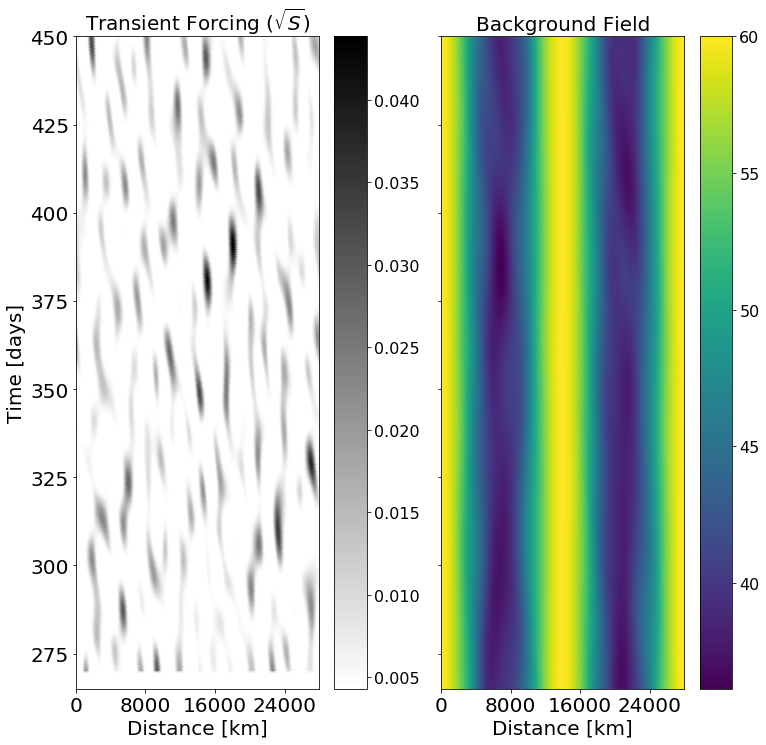

In [37]:
fig,axes=plt.subplots(1,2,figsize=(12.,12.),sharey=True)
im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,np.sqrt(S[it0:]),shading='Gouraud',cmap='gist_gray_r')
axes[0].set_ylim(265,450)
cbar=plt.colorbar(im1,ax=axes[0])#,label="Forcing Strength [m/s$^2$]")
cbar.ax.tick_params(labelsize=16)
axes[0].set_title(r"Transient Forcing $(\sqrt{S})$",fontsize=20)
im2=axes[1].pcolormesh(x/1e3,t[it0:]/86400,(C[it0:]),shading='Gouraud',cmap='viridis')
#plt.ylim(270,300)
#plt.xlim(7000,12000)
cbar=plt.colorbar(im2,ax=axes[1])#,label="Background Amplitude",ax=axes[1])
cbar.ax.tick_params(labelsize=16)
axes[1].set_title("Background Field",fontsize=20)
axes[0].set_ylabel("Time [days]",fontsize=20)
axes[0].set_xlabel("Distance [km]",fontsize=20)
axes[1].set_xlabel("Distance [km]",fontsize=20)
axes[0].tick_params(axis="x",labelsize=20)
axes[0].tick_params(axis="x",labelsize=20)
axes[0].set_xticks(np.arange(0,30000,8000))
axes[1].tick_params(axis="x",labelsize=20)
axes[1].set_xticks(np.arange(0,30000,8000))
axes[0].tick_params(axis="y",labelsize=20)

# plt.savefig("June_17_2019_figures/force_gamma=%i_2aY=%1.1f_beta=%i.pdf"%(peaks[j],a2Ys[j],betas[j]))  


In [20]:
Lx=28000.0e3
A0 = Ys[j]*(1-np.cos(2*2*np.pi*x/Lx))
cg = 20 
ua = cond.beta-cg-cond.alpha*(Ahat+A0[np.newaxis,:])

In [21]:
gamma = 4*cond.alpha*F/C**2

The flux saturation $\Gamma(x,t)$ is defined as $$\Gamma(x,t) = \frac{4\alpha F(x,t)}{C^2(x)}.$$

Rather than plotting the saturation itself, we instead plot $\log_{10}(1-\Gamma)$. This means we can see the asymptotic approach to $\Gamma=1$, and actually see that the transition is rather sharp, and makes it clear that blocks are outlined by regions of flux saturation, with the highest saturation actually downstream of the area of strongest slowdown.

This becomes then a tempting mask for identifying blocks.

In [22]:
masked = gamma.copy()
masked[np.where(gamma<0.99999)]=0
masked[np.where(gamma>=0.99999)]=1

In [23]:
threshu = 10
ugrad = -(np.gradient(ua[it0:],axis=1))
umask = ((ugrad - np.mean(ugrad))/np.std(ugrad) > threshu)*1.0
uct,umask = count_blocks(umask,80,10)
print(uct)
uts = t[it0:][np.where(umask>0.5)[0]]/86400
uxs = x[np.where(umask>0.5)[1]]/1e3

18.0


In [24]:
# fig,axes=plt.subplots(1,4,figsize=(22.,9),sharey=True)

# im=axes[0].pcolormesh(x/1e3,t[:]/86400,(Ahat+A0[np.newaxis,:])[:],
#                       shading='Gouraud',cmap='viridis')
# axes[0].set_ylim(260,450)
# axes[0].set_ylabel("Time [days]",fontsize=20)
# #plt.colorbar(im)#,label="A [m/s]",ax=axes[0])
# cbar=plt.colorbar(im,ax=axes[0])
# cbar.ax.tick_params(labelsize=16)
# # axes[0].set_title("Local Wave Activity",fontsize=20)
# axes[0].set_title(r"$A_{0}(x)+\hat{A}(x,t)$",fontsize=20)
# axes[0].set_xlabel("Distance [km]",fontsize=20)
# axes[0].tick_params(axis="x",labelsize=18)
# axes[0].tick_params(axis="y",labelsize=18)
# axes[0].set_xticks(np.arange(0,30000,8000))

# im=axes[1].pcolormesh(x/1e3,t[it0:]/86400,(ua)[it0:],shading='Gouraud',
#                       cmap='viridis')
# cbar=plt.colorbar(im,ax=axes[1])
# cbar.ax.tick_params(labelsize=16)
# axes[1].set_ylim(260,450)
# axes[1].set_ylabel("Time [days]",fontsize=20)
# axes[1].set_xlabel("Distance [km]",fontsize=20)
# axes[1].set_title("u(x,t)",fontsize=20)
# axes[1].tick_params(axis="x",labelsize=18)
# axes[1].set_xticks(np.arange(0,30000,8000))



# im=axes[2].pcolormesh(x/1e3,t[it0:]/86400,
#                   np.log10(np.maximum(1.0-(gamma)[it0:],1.0e-6)),
#                   shading='Gouraud',cmap='inferno_r')
# cbar=plt.colorbar(im,ax=axes[2])
# cbar.ax.tick_params(labelsize=16)
# axes[2].set_ylim(260,450)
# axes[2].set_ylabel("Time [days]",fontsize=20)
# axes[2].set_xlabel("Distance [km]",fontsize=20)
# axes[2].set_title(r"$log_{10}(1-\Gamma)$",fontsize=20)
# axes[2].tick_params(axis="x",labelsize=18)
# axes[2].set_xticks(np.arange(0,30000,8000))


# im=axes[3].pcolormesh(x/1e3,t[it0:]/86400,
#                        ((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,
#                        shading='Gouraud',cmap='Greys')
# axes[3].scatter(uxs,uts,s=40,marker='*',color='b')
# # cbar=plt.colorbar(im,ax=axes[3])
# # cbar.ax.tick_params(labelsize=16)
# axes[3].set_ylim(260,450)
# axes[3].set_ylabel("Time [days]",fontsize=20)
# axes[3].set_xlabel("Distance [km]",fontsize=20)
# axes[3].set_title("mask",fontsize=20)
# axes[3].tick_params(axis="x",labelsize=18)
# axes[3].set_xticks(np.arange(0,30000,8000))

# # plt.savefig("figure_pdf/figure_gamma=3_2aY=0.5_beta=40.png")

# # 2a,b

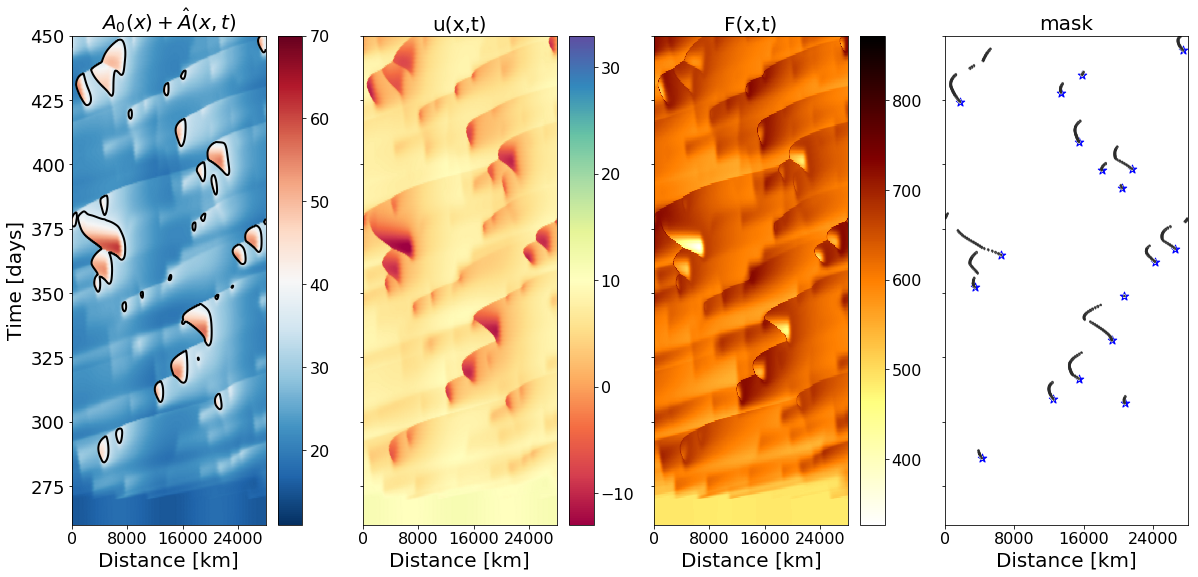

In [39]:
sat=C/(2*cond.alpha)

fig,axes=plt.subplots(1,4,figsize=(20.,9),sharey=True)

im=axes[0].pcolormesh(x/1e3,t[it0:]/86400,(Ahat+A0[np.newaxis,:])[it0:], vmin=11, vmax=70,
                      shading='Gouraud',cmap='RdBu_r')
axes[0].contour(x/1e3,t[it0:]/86400,
                  (Ahat+A0)[it0:], levels = [np.max((sat+A0)[it0:])], colors='k', linewidths=2)
axes[0].set_ylim(260,450)
axes[0].set_ylabel("Time [days]",fontsize=20)
#plt.colorbar(im)#,label="A [m/s]",ax=axes[0])
cbar=plt.colorbar(im,ax=axes[0])
cbar.ax.tick_params(labelsize=16)
# axes[0].set_title("Local Wave Activity",fontsize=20)
axes[0].set_title(r"$A_{0}(x)+\hat{A}(x,t)$",fontsize=20)
axes[0].set_xlabel("Distance [km]",fontsize=20)
axes[0].tick_params(axis="x",labelsize=16)
axes[0].tick_params(axis="y",labelsize=18)
axes[0].set_xticks(np.arange(0,30000,8000))

im=axes[1].pcolormesh(x/1e3,t[it0:]/86400,(ua)[it0:],shading='Gouraud', vmin=-13, vmax=33,
                      cmap='Spectral')
cbar=plt.colorbar(im,ax=axes[1])
cbar.ax.tick_params(labelsize=16)
axes[1].set_ylim(260,450)
# axes[1].set_ylabel("Time [days]",fontsize=20)
axes[1].set_xlabel("Distance [km]",fontsize=20)
axes[1].set_title("u(x,t)",fontsize=20)
axes[1].tick_params(axis="x",labelsize=16)
axes[1].set_xticks(np.arange(0,30000,8000))

# im=axes[2].contourf(x/1e3,t[it0:]/86400,F[it0:],np.arange(300,1800+5,5),cmap='afmhot_r')
im=axes[2].pcolormesh(x/1e3,t[it0:]/86400,F[it0:],vmin= 327,vmax= 872,cmap='afmhot_r')
cbar=plt.colorbar(im,ax=axes[2])
cbar.ax.tick_params(labelsize=16)
axes[2].set_ylim(260,450)
# axes[2].set_ylabel("Time [days]",fontsize=20)
axes[2].set_xlabel("Distance [km]",fontsize=20)
axes[2].set_title("F(x,t)",fontsize=20)
axes[2].tick_params(axis="x",labelsize=16)
axes[2].set_xticks(np.arange(0,30000,8000))


# im=axes[3].pcolormesh(x/1e3,t[it0:]/86400,
#                        ((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,
#                        shading='Gouraud',cmap='Greys')
im=axes[3].contour(x/1e3,t[it0:]/86400,
                       ((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,linewidths=2, 
                       cmap='Greys')
axes[3].scatter(uxs,uts,s=80,marker='*',color='b')
# cbar=plt.colorbar(im,ax=axes[3])
# cbar.ax.tick_params(labelsize=16)
axes[3].set_ylim(260,450)
# axes[3].set_ylabel("Time [days]",fontsize=20)
axes[3].set_xlabel("Distance [km]",fontsize=20)
axes[3].set_title("mask",fontsize=20)
axes[3].tick_params(axis="x",labelsize=16)
axes[3].set_xticks(np.arange(0,30000,8000))

# Junee

# 2a,b

In [97]:
# fig.savefig("June_19_2019_figures/figure_all_gamma=%i_2aY=%1.1f_beta=%i_corrected.png"%(peaks[j],a2Ys[j],betas[j]))





In [41]:
fig.savefig("June_22_2019_figures/figure_all_gamma=%i_2aY=%1.1f_beta=%i_corrected.png"%(peaks[j],a2Ys[j],betas[j]))


In [31]:
print (np.min((Ahat+A0[np.newaxis,:])[it0:])); print (np.max((Ahat+A0[np.newaxis,:])[it0:]))

15.423581719775825
61.206255661756316


In [32]:
print (np.min((ua)[it0:])); print (np.max((ua)[it0:]))

-13.663440613965975
11.517030054123296


In [33]:
print (np.min((F)[it0:])); print (np.max((F)[it0:]))

327.49174195678205
727.270466467268


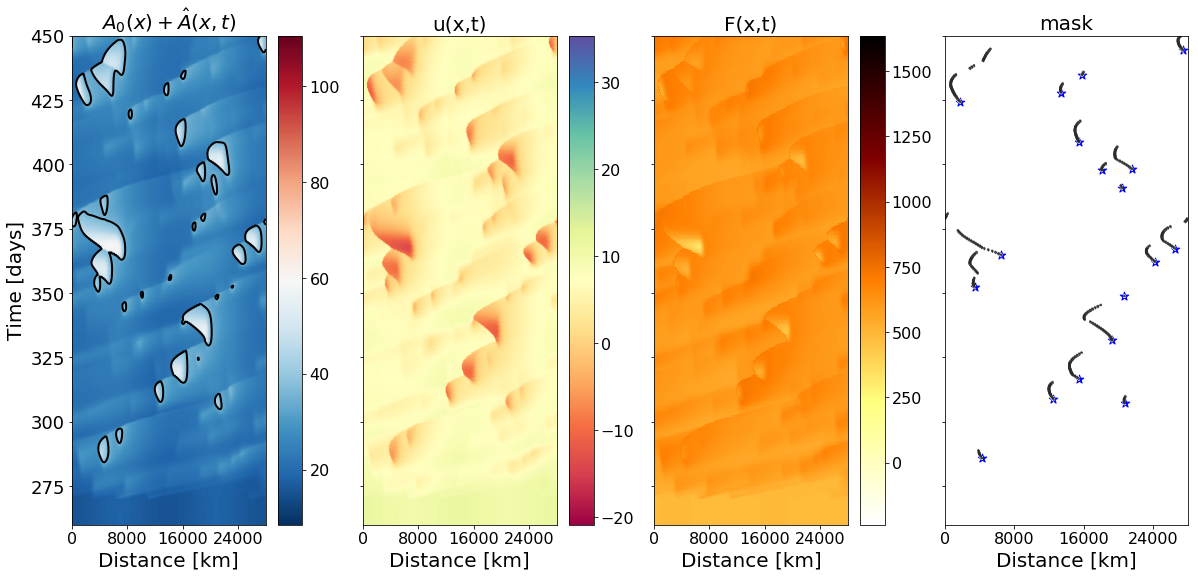

In [42]:
sat=C/(2*cond.alpha)

fig,axes=plt.subplots(1,4,figsize=(20.,9),sharey=True)

im=axes[0].pcolormesh(x/1e3,t[it0:]/86400,(Ahat+A0[np.newaxis,:])[it0:], vmin=8.46, vmax=110.6,
                      shading='Gouraud',cmap='RdBu_r')
axes[0].contour(x/1e3,t[it0:]/86400,
                  (Ahat+A0)[it0:], levels = [np.max((sat+A0)[it0:])], colors='k', linewidths=2)
axes[0].set_ylim(260,450)
axes[0].set_ylabel("Time [days]",fontsize=20)
#plt.colorbar(im)#,label="A [m/s]",ax=axes[0])
cbar=plt.colorbar(im,ax=axes[0])
cbar.ax.tick_params(labelsize=16)
# axes[0].set_title("Local Wave Activity",fontsize=20)
axes[0].set_title(r"$A_{0}(x)+\hat{A}(x,t)$",fontsize=20)
axes[0].set_xlabel("Distance [km]",fontsize=20)
axes[0].tick_params(axis="x",labelsize=16)
axes[0].tick_params(axis="y",labelsize=18)
axes[0].set_xticks(np.arange(0,30000,8000))

im=axes[1].pcolormesh(x/1e3,t[it0:]/86400,(ua)[it0:],shading='Gouraud', vmin=-20.84, vmax=35.34,
                      cmap='Spectral')
cbar=plt.colorbar(im,ax=axes[1])
cbar.ax.tick_params(labelsize=16)
axes[1].set_ylim(260,450)
# axes[1].set_ylabel("Time [days]",fontsize=20)
axes[1].set_xlabel("Distance [km]",fontsize=20)
axes[1].set_title("u(x,t)",fontsize=20)
axes[1].tick_params(axis="x",labelsize=16)
axes[1].set_xticks(np.arange(0,30000,8000))

# im=axes[2].contourf(x/1e3,t[it0:]/86400,F[it0:],np.arange(300,1800+5,5),cmap='afmhot_r')
im=axes[2].pcolormesh(x/1e3,t[it0:]/86400,F[it0:],vmin= -237.78,vmax= 1636.31,cmap='afmhot_r')
cbar=plt.colorbar(im,ax=axes[2])
cbar.ax.tick_params(labelsize=16)
axes[2].set_ylim(260,450)
# axes[2].set_ylabel("Time [days]",fontsize=20)
axes[2].set_xlabel("Distance [km]",fontsize=20)
axes[2].set_title("F(x,t)",fontsize=20)
axes[2].tick_params(axis="x",labelsize=16)
axes[2].set_xticks(np.arange(0,30000,8000))


# im=axes[3].pcolormesh(x/1e3,t[it0:]/86400,
#                        ((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,
#                        shading='Gouraud',cmap='Greys')
im=axes[3].contour(x/1e3,t[it0:]/86400,
                       ((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,linewidths=2, 
                       cmap='Greys')
axes[3].scatter(uxs,uts,s=80,marker='*',color='b')
# cbar=plt.colorbar(im,ax=axes[3])
# cbar.ax.tick_params(labelsize=16)
axes[3].set_ylim(260,450)
# axes[3].set_ylabel("Time [days]",fontsize=20)
axes[3].set_xlabel("Distance [km]",fontsize=20)
axes[3].set_title("mask",fontsize=20)
axes[3].tick_params(axis="x",labelsize=16)
axes[3].set_xticks(np.arange(0,30000,8000))

# plt.savefig("June_19_2019_figures/figure_all_gamma=%i_2aY=%1.1f_beta=%i.png"%(peaks[j],a2Ys[j],betas[j]))

# 2a,b

In [43]:
fig.savefig("June_22_2019_figures/option1/figure_all_gamma=%i_2aY=%1.1f_beta=%i_corrected.png"%(peaks[j],a2Ys[j],betas[j]))


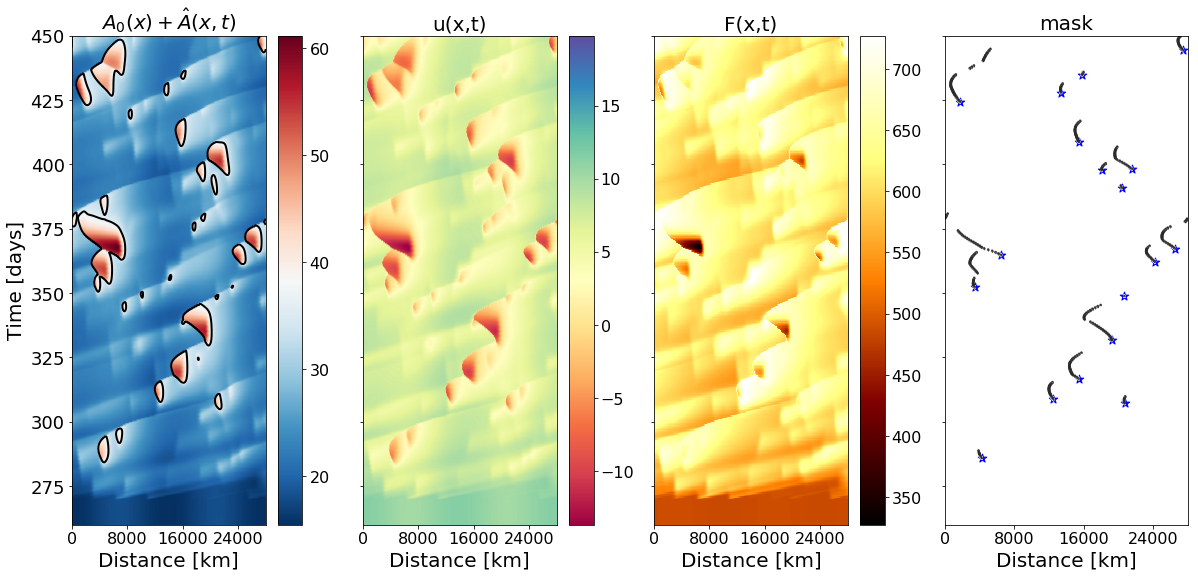

In [46]:
sat=C/(2*cond.alpha)

fig,axes=plt.subplots(1,4,figsize=(20.,9),sharey=True)

im=axes[0].pcolormesh(x/1e3,t[it0:]/86400,(Ahat+A0[np.newaxis,:])[it0:], vmin=np.min((Ahat+A0[np.newaxis,:])[it0:]), vmax=np.max((Ahat+A0[np.newaxis,:])[it0:]),
                      shading='Gouraud',cmap='RdBu_r')
axes[0].contour(x/1e3,t[it0:]/86400,
                  (Ahat+A0)[it0:], levels = [np.max((sat+A0)[it0:])], colors='k', linewidths=2)
axes[0].set_ylim(260,450)
axes[0].set_ylabel("Time [days]",fontsize=20)
#plt.colorbar(im)#,label="A [m/s]",ax=axes[0])
cbar=plt.colorbar(im,ax=axes[0])
cbar.ax.tick_params(labelsize=16)
# axes[0].set_title("Local Wave Activity",fontsize=20)
axes[0].set_title(r"$A_{0}(x)+\hat{A}(x,t)$",fontsize=20)
axes[0].set_xlabel("Distance [km]",fontsize=20)
axes[0].tick_params(axis="x",labelsize=16)
axes[0].tick_params(axis="y",labelsize=18)
axes[0].set_xticks(np.arange(0,30000,8000))

im=axes[1].pcolormesh(x/1e3,t[it0:]/86400,(ua)[it0:],shading='Gouraud', vmin=np.min(ua), vmax=np.max(ua),
                      cmap='Spectral')
cbar=plt.colorbar(im,ax=axes[1])
cbar.ax.tick_params(labelsize=16)
axes[1].set_ylim(260,450)
# axes[1].set_ylabel("Time [days]",fontsize=20)
axes[1].set_xlabel("Distance [km]",fontsize=20)
axes[1].set_title("u(x,t)",fontsize=20)
axes[1].tick_params(axis="x",labelsize=16)
axes[1].set_xticks(np.arange(0,30000,8000))


# im=axes[2].contourf(x/1e3,t[it0:]/86400,F[it0:],np.arange(300,1800+5,5),cmap='afmhot_r')
im=axes[2].pcolormesh(x/1e3,t[it0:]/86400,F[it0:],vmin= np.min(F[it0:]),vmax= np.max(F[it0:]),cmap='afmhot')
cbar=plt.colorbar(im,ax=axes[2])
cbar.ax.tick_params(labelsize=16)
axes[2].set_ylim(260,450)
# axes[2].set_ylabel("Time [days]",fontsize=20)
axes[2].set_xlabel("Distance [km]",fontsize=20)
axes[2].set_title("F(x,t)",fontsize=20)
axes[2].tick_params(axis="x",labelsize=16)
axes[2].set_xticks(np.arange(0,30000,8000))


# im=axes[3].pcolormesh(x/1e3,t[it0:]/86400,
#                        ((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,
#                        shading='Gouraud',cmap='Greys')
im=axes[3].contour(x/1e3,t[it0:]/86400,
                       ((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,linewidths=2, 
                       cmap='Greys')
axes[3].scatter(uxs,uts,s=80,marker='*',color='b')
# cbar=plt.colorbar(im,ax=axes[3])
# cbar.ax.tick_params(labelsize=16)
axes[3].set_ylim(260,450)
# axes[3].set_ylabel("Time [days]",fontsize=20)
axes[3].set_xlabel("Distance [km]",fontsize=20)
axes[3].set_title("mask",fontsize=20)
axes[3].tick_params(axis="x",labelsize=16)
axes[3].set_xticks(np.arange(0,30000,8000))

# plt.savefig("June_19_2019_figures/figure_all_gamma=%i_2aY=%1.1f_beta=%i.png"%(peaks[j],a2Ys[j],betas[j]))

# 2a,b

In [47]:
fig.savefig("June_22_2019_figures/option3/figure_all_gamma=%i_2aY=%1.1f_beta=%i_corrected.png"%(peaks[j],a2Ys[j],betas[j]))


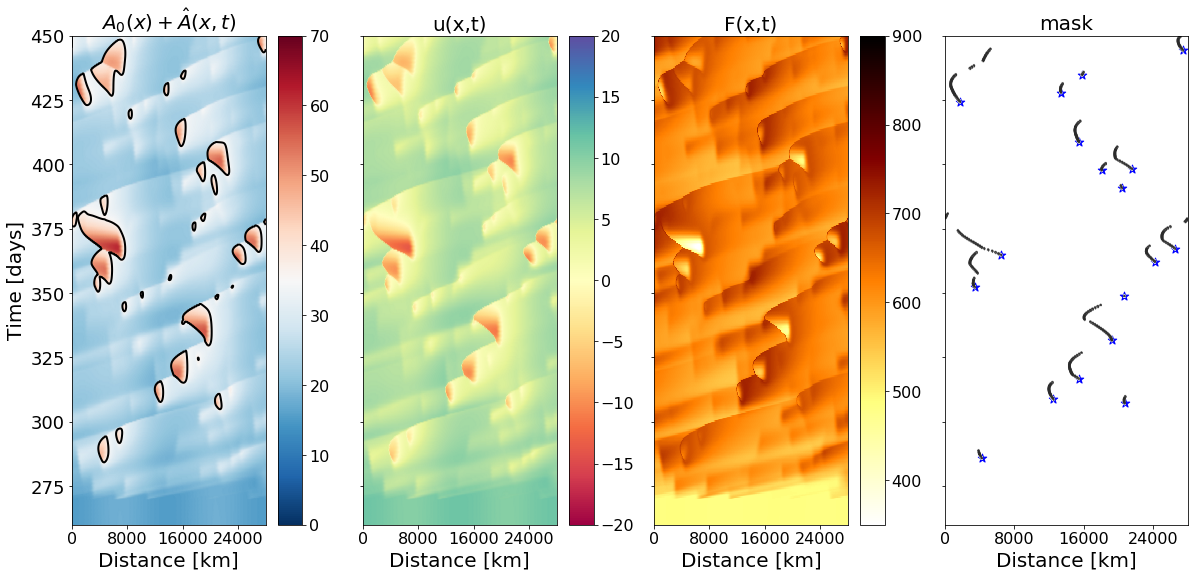

In [49]:
sat=C/(2*cond.alpha)

fig,axes=plt.subplots(1,4,figsize=(20.,9),sharey=True)

im=axes[0].pcolormesh(x/1e3,t[it0:]/86400,(Ahat+A0[np.newaxis,:])[it0:], vmin=0, vmax=70,
                      shading='Gouraud',cmap='RdBu_r')
axes[0].contour(x/1e3,t[it0:]/86400,
                  (Ahat+A0)[it0:], levels = [np.max((sat+A0)[it0:])], colors='k', linewidths=2)
axes[0].set_ylim(260,450)
axes[0].set_ylabel("Time [days]",fontsize=20)
#plt.colorbar(im)#,label="A [m/s]",ax=axes[0])
cbar=plt.colorbar(im,ax=axes[0])
cbar.ax.tick_params(labelsize=16)
# axes[0].set_title("Local Wave Activity",fontsize=20)
axes[0].set_title(r"$A_{0}(x)+\hat{A}(x,t)$",fontsize=20)
axes[0].set_xlabel("Distance [km]",fontsize=20)
axes[0].tick_params(axis="x",labelsize=16)
axes[0].tick_params(axis="y",labelsize=18)
axes[0].set_xticks(np.arange(0,30000,8000))

im=axes[1].pcolormesh(x/1e3,t[it0:]/86400,(ua)[it0:],shading='Gouraud', vmin=-20, vmax=20,
                      cmap='Spectral')
cbar=plt.colorbar(im,ax=axes[1])
cbar.ax.tick_params(labelsize=16)
axes[1].set_ylim(260,450)
# axes[1].set_ylabel("Time [days]",fontsize=20)
axes[1].set_xlabel("Distance [km]",fontsize=20)
axes[1].set_title("u(x,t)",fontsize=20)
axes[1].tick_params(axis="x",labelsize=16)
axes[1].set_xticks(np.arange(0,30000,8000))

# im=axes[2].contourf(x/1e3,t[it0:]/86400,F[it0:],np.arange(300,1800+5,5),cmap='afmhot_r')
im=axes[2].pcolormesh(x/1e3,t[it0:]/86400,F[it0:],vmin= 350,vmax= 900,cmap='afmhot_r')
cbar=plt.colorbar(im,ax=axes[2])
cbar.ax.tick_params(labelsize=16)
axes[2].set_ylim(260,450)
# axes[2].set_ylabel("Time [days]",fontsize=20)
axes[2].set_xlabel("Distance [km]",fontsize=20)
axes[2].set_title("F(x,t)",fontsize=20)
axes[2].tick_params(axis="x",labelsize=16)
axes[2].set_xticks(np.arange(0,30000,8000))


# im=axes[3].pcolormesh(x/1e3,t[it0:]/86400,
#                        ((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,
#                        shading='Gouraud',cmap='Greys')
im=axes[3].contour(x/1e3,t[it0:]/86400,
                       ((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,linewidths=2, 
                       cmap='Greys')
axes[3].scatter(uxs,uts,s=80,marker='*',color='b')
# cbar=plt.colorbar(im,ax=axes[3])
# cbar.ax.tick_params(labelsize=16)
axes[3].set_ylim(260,450)
# axes[3].set_ylabel("Time [days]",fontsize=20)
axes[3].set_xlabel("Distance [km]",fontsize=20)
axes[3].set_title("mask",fontsize=20)
axes[3].tick_params(axis="x",labelsize=16)
axes[3].set_xticks(np.arange(0,30000,8000))

# plt.savefig("June_19_2019_figures/figure_all_gamma=%i_2aY=%1.1f_beta=%i.png"%(peaks[j],a2Ys[j],betas[j]))

# 2a,b

In [50]:
fig.savefig("June_22_2019_figures/option5/figure_all_gamma=%i_2aY=%1.1f_beta=%i_corrected.pdf"%(peaks[j],a2Ys[j],betas[j]))


In [51]:
fig.savefig("June_22_2019_figures/option5/figure_all_gamma=%i_2aY=%1.1f_beta=%i_corrected.png"%(peaks[j],a2Ys[j],betas[j]))
